In [1]:
import numpy as np
import torch

from pyronn.ct_reconstruction.geometry.geometry import Geometry
from pyronn.ct_reconstruction.helpers.filters import filters
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan
from pyronn.ct_reconstruction.helpers.trajectories.circular_trajectory import circular_trajectory_2d
from pyronn.ct_reconstruction.layers.backprojection_2d import ParallelBackProjection2D
from pyronn.ct_reconstruction.layers.projection_2d import ParallelProjection2D


In [2]:
# Initializing CT geometry parameters:

# Volume parameters:
volume_size = 362  # size of the volume/image
volume_shape = [volume_size, volume_size]  # shape of the volume as [height, width]
volume_spacing = [1, 1]  # spacing between pixels in the volume

# Detector parameters:
detector_shape = [513]  # shape of the detector
detector_spacing = [1]  # spacing between detector pixels

# Trajectory parameters:
number_of_projections = 1000  # number of projections in the sinogram
angular_range = -np.pi  # angular range of the trajectory (half-circle in this case)

# Create an instance of the Geometry class and initialize it with the above parameters
geometry = Geometry()
geometry.init_from_parameters(volume_shape=volume_shape, volume_spacing=volume_spacing,
                              detector_shape=detector_shape, detector_spacing=detector_spacing,
                              number_of_projections=number_of_projections, angular_range=angular_range,
                              trajectory=circular_trajectory_2d)


In [3]:
phantom = shepp_logan.shepp_logan_enhanced(volume_shape)
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()

sinogram = ParallelProjection2D().forward(phantom, **geometry)

In [4]:
# Filtering the sinogram in the frequency domain:

# Create the Shepp-Logan filter in the frequency domain
reco_filter = torch.tensor(
    filters.ram_lak_2D(geometry.detector_shape, geometry.detector_spacing, geometry.number_of_projections)).cuda()
print(reco_filter.shape)

# Perform the Fast Fourier Transform (FFT) on the sinogram
x = torch.fft.fft(sinogram, dim=-1)
print(x.shape)
# Multiply the Fourier-transformed sinogram with the filter
x = torch.multiply(x, reco_filter)
print(x.shape)
# Inverse FFT to get the filtered sinogram in the spatial domain
x = torch.fft.ifft(x, dim=-1).real
print(x.shape)


torch.Size([1000, 513])
torch.Size([1, 1000, 513])
torch.Size([1, 1000, 513])
torch.Size([1, 1000, 513])


In [5]:
# Backprojecting the filtered sinogram to obtain the reconstructed image:

# Perform parallel backprojection on the filtered sinogram
reco = ParallelBackProjection2D().forward(x.float().contiguous(), **geometry)

# Convert the reconstructed tensor back to a numpy array for further processing or visualization
reco = reco.cpu().numpy()
print(reco.shape)

(1, 362, 362)


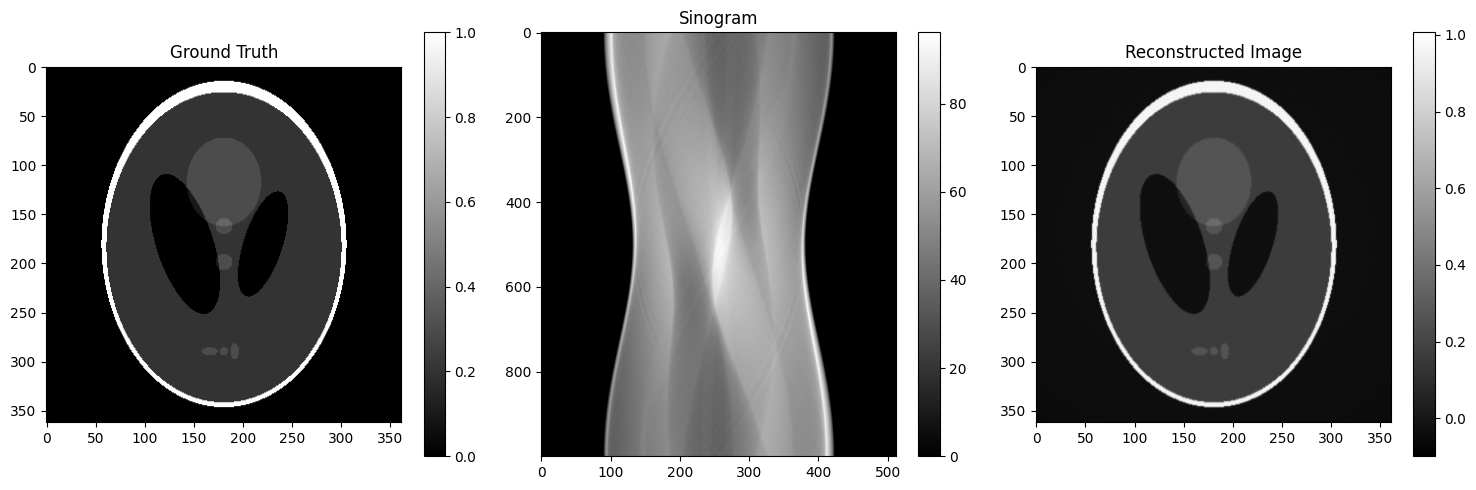

In [6]:
import matplotlib.pyplot as plt

# 1. Display the original Shepp-Logan phantom.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(phantom.squeeze().cpu(), cmap='gray')
plt.title('Ground Truth')
plt.colorbar()

# 2. Display the resulting sinogram.
plt.subplot(1, 3, 2)
plt.imshow(sinogram.squeeze().cpu(), cmap='gray', aspect='auto')
plt.title('Sinogram')
plt.colorbar()

# 3. Display the reconstructed image.
plt.subplot(1, 3, 3)
plt.imshow(reco.squeeze(), cmap='gray')
plt.title('Reconstructed Image')
plt.colorbar()

plt.tight_layout()
plt.show()
